In [1]:
import numpy as np
import glob
import datetime
from pmap import getmap
import pandas
import os
import lxml.etree as et
from netCDF4 import Dataset
import sys

In [2]:
%matplotlib notebook

## Read tide gauges data

In [3]:
OFILE='/mnt/pandora/Projects_Critech/EX_2015_CoastAlRisk/maps/data/s_b_data.txt'

In [4]:
obs=pandas.read_csv(OFILE,delimiter='\t')

In [5]:
obs

,ID,NAME,latobs,lonobs,latcalc,loncalc
0,1630,Almeira,36.8300,-2.4800,36.72506,-2.468386
1,1706,Valencia,39.4400,-0.3100,39.44040,-0.299000
2,819,Barcelona,41.3400,2.1600,41.27749,2.213909
3,1461,Palma de Mallorca,39.5600,2.6380,39.39457,2.614552
4,1741,Sete,43.3976,3.6991,43.31857,3.761195
5,1500,Corsica,42.9670,9.3500,43.09528,9.267036
6,1841,Carloforte,39.1480,8.3095,39.22599,8.231240
7,1848,Imperia,43.8783,8.0189,43.83057,8.149480
8,1846,Genova,44.4101,8.9255,44.32259,8.919400
9,1843,Civitavecchia,42.0940,11.7896,41.99920,11.677270


## Read HyFlux data

In [10]:
# define year
Y=2016

In [11]:
PATH='/mnt/ECMWF/processed/{}/FIX_MED_SEA/'.format(Y)  # ECMWF

### read bathymetry of first folder to define grid

In [12]:
folders=glob.glob(PATH+'calc_*')

In [13]:
filename=folders[0]+'/bathymetry.tif'
grid = getmap(filename)

gt=grid.GeoTr

width=grid.NCOLS
height=grid.NROWS

minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5]
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3]

lon=np.linspace(minx,maxx,width,endpoint=True)
lat=np.linspace(miny,maxy,height,endpoint=True)


### define start time of runs

In [14]:
odate=datetime.datetime.strptime(folders[0][-11:],'%Y%m%d.%H')
print odate

2016-01-01 00:00:00


We can check the restart date by parsing the locations.xml file ...

In [15]:
folders[0]+'/locations.xml'

'/mnt/ECMWF/processed/2016/FIX_MED_SEA/calc_20160101.00/locations.xml'

In [16]:
tree0=et.ElementTree(file=folders[0]+'/locations.xml')
for elem in list(tree0.getiterator()):
    if elem.tag == 'pubDate':
                 tinit=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                 break
tinit

datetime.datetime(2016, 1, 1, 0, 0)

In [17]:
#SELECT POINT from database above
point=14

In [18]:
plat,plon=obs['latcalc'][point],obs['loncalc'][point]

In [19]:
i=np.abs(lat-plat).argmin()
j=np.abs(lon-plon).argmin()


In [20]:
print i,j

216 292


In [21]:
obs['ID'][point]

1866

### specify dates 

In [22]:
t0='20160121.00'

In [48]:
t1='20160121.00'

In [49]:
tstart=datetime.datetime.strptime(t0,'%Y%m%d.%H')
tend=datetime.datetime.strptime(t1,'%Y%m%d.%H')


In [50]:
dt=(tend-tstart).total_seconds()
ndt=dt/(3600*12)
ndt=np.int(ndt)+1


## read from netCDF files

In [51]:
combined=[] # store time and height
tw=[]
tstamp = [] # for use later

In [52]:
# define the 
dt0=0
dt1=72

In [53]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:

        filename=PATH+'calc_{}/NETCDF_H.nc'.format(dstamp)
        d =  Dataset(filename)
        ha=d.variables['HA'][:,i,j] # all values
        t=d.variables['TIME'][:]
        
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=dt0)).flatten()[0]
        
        # check availability of values and take the minimum
        tmax=(t[-1]-t[iw1])/3600.
        tlimit=min(datetime.timedelta(hours=tmax),datetime.timedelta(hours=dt1))
        
        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(seconds=tlimit.total_seconds())).flatten()[0]
                
        tw.append(tp[iw1:iw2+1])
        combined.append(ha[iw1:iw2+1])
        
        tstamp.append(dstamp)

    except Exception as e:
        sys.stdout.write('  > {}'.format(e))
        sys.stdout.write('  > problem with netcdf file, skiping'.format(dstamp))
        sys.stdout.write('\n')        




20160121.00

In [54]:
#Create the MultiIndex
rt=[]
k=0
ttw=[]
for ida in tstamp:
    g=np.size(tw[k])*[ida]
    gr=[]
    for ti in g:
        gr.append(datetime.datetime.strptime(ti,'%Y%m%d.%H'))
    ttw.append([(item-tw[k][0]).total_seconds()/3600. for item in tw[k]])
    rt=np.append(rt,gr)
    k += 1

In [55]:
index=[np.array(rt).ravel(),[item for sublist in tw for item in sublist]]

In [56]:
pIndex=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [59]:
data=[item for sublist in combined for item in sublist] # unravel list

In [60]:
res=pandas.DataFrame(data,index=pIndex,columns=['h - netCDF'])

<IPython.core.display.Javascript object>


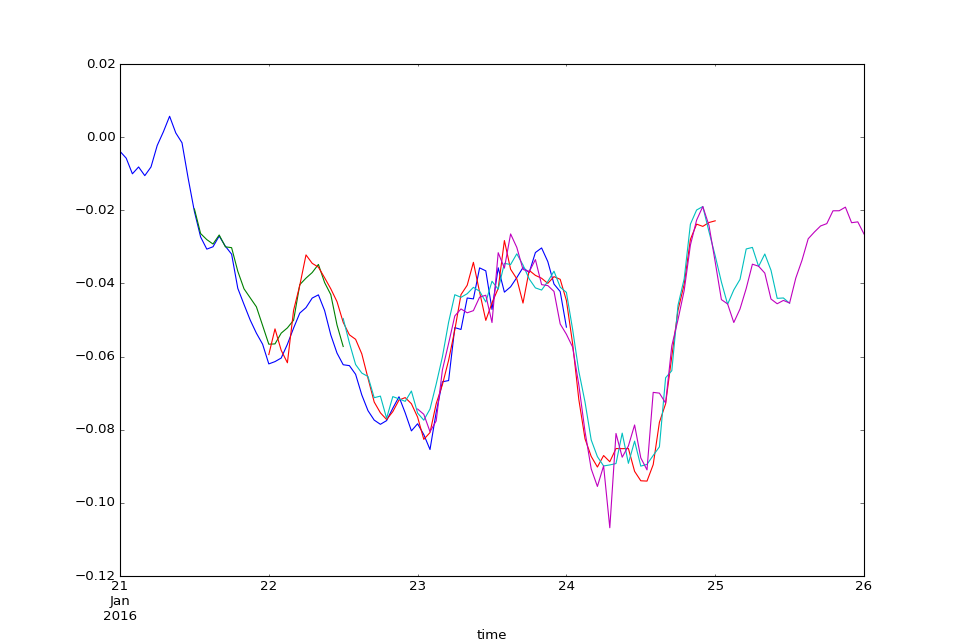

In [34]:
#plot
ax=res.unstack(level=0).plot(figsize=(12,8),legend=False)

### Reading from tif files

In [31]:
combined=[] # store time and height
tw=[]
tstamp = [] # for use later

In [32]:
for it in range(ndt):
    idate=tstart+datetime.timedelta(hours=12*it)
    dstamp=datetime.datetime.strftime(idate,'%Y%m%d.%H')
    
    # track completion
    sys.stdout.write('\r')
    sys.stdout.write(dstamp)
    sys.stdout.flush() 

    try:
        tree0=et.ElementTree(file=PATH+'calc_{}/locations.xml'.format(dstamp))
        for elem in list(tree0.getiterator()):
            if elem.tag == 'pubDate':
                tn=datetime.datetime.strptime(elem.text,'%d %b %Y %H:%M')
                break
        if tn != tinit :
            sys.stdout.write( '  > restart date : {}'.format(tn)) # new restart day
            tinit=tn
        
    except:
        sys.stdout.write('  > problem with locations.xml file')
        pass


    try:
        hfiles=glob.glob(PATH+'calc_{}/TIF_H*.tif'.format(dstamp))

        t=[np.int(l.split('_')[-1].split('.')[0]) for l in hfiles]
        
        
        # choose the files from the first 12 hours
        tp=[]
        for ts in t:
            if t[0] == 0 :
                tp.append(idate+datetime.timedelta(seconds=ts))
                tinit=idate
            else:
                tp.append(tinit+datetime.timedelta(seconds=ts))
                       
        iw1=np.argwhere(np.array(tp)==idate+datetime.timedelta(hours=dt0)).flatten()[0]
    
        # check availability of values and take the minimum

        tmax=(t[-1]-t[iw1])/3600.  # compute all values after the current run timestamp
        tlimit=min(datetime.timedelta(hours=tmax),datetime.timedelta(hours=dt1)) 

        iw2=np.argwhere(np.array(tp)==idate+datetime.timedelta(seconds=tlimit.total_seconds())).flatten()[0]
        tw.append(tp[iw1:iw2+1])
                
        
        for ifile in hfiles[iw1:iw2+1]:  
            dat=getmap(ifile)
            combined.append(np.flipud(dat.data)[i,j])
        
        tstamp.append(dstamp)

    except Exception as e:
        print e
        sys.stdout.write('  > problem with TIF files, skiping'.format(dstamp))
        sys.stdout.write('\n')
        

20150123.00

In [33]:
#Create the MultiIndex
rt=[]
ttw=[]
k=0
for ida in tstamp:
    g=np.size(tw[k])*[ida]
    gr=[]
    for ti in g:
        gr.append(datetime.datetime.strptime(ti,'%Y%m%d.%H'))
    ttw.append([(item-tw[k][0]).total_seconds()/3600. for item in tw[k]])
    rt=np.append(rt,gr)
    k += 1

In [34]:
index=[np.array(rt).ravel(),[item for sublist in tw for item in sublist]]

In [35]:
pIndex=pandas.MultiIndex.from_arrays(index,names=['run date','time'])

In [36]:
res1=pandas.DataFrame(np.array(combined).ravel(),index=pIndex,columns=['h - TIFF'])

<IPython.core.display.Javascript object>


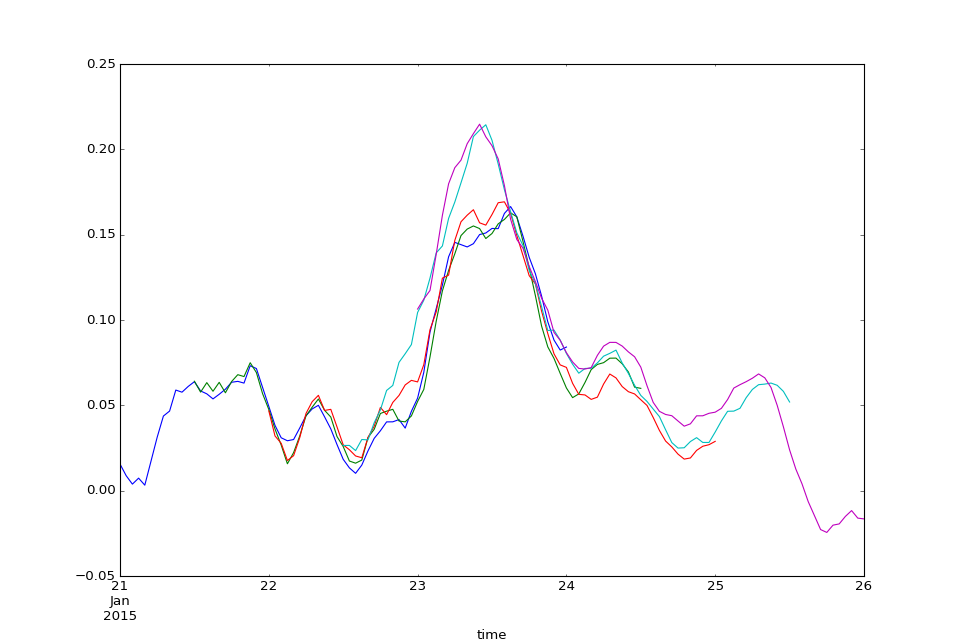

In [37]:
#plot
ax1=res1.unstack(level=0).plot(figsize=(12,8),legend=False)

<IPython.core.display.Javascript object>


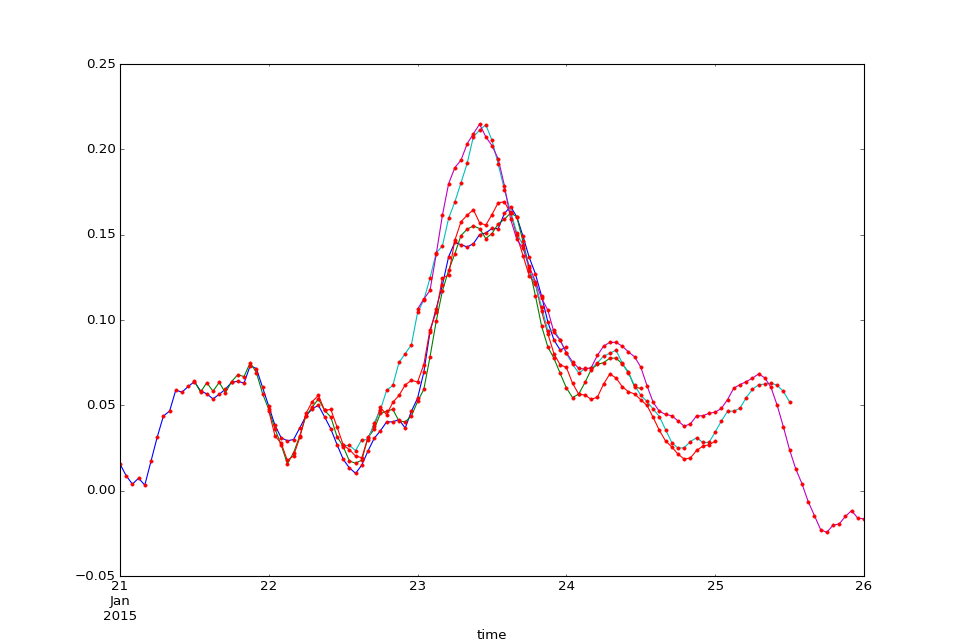

In [38]:
#plot both
ax1 = res1.unstack(level=0).plot(figsize=(12,8),legend=False)
res.unstack(level=0).plot(ax=ax1,color='red', linestyle='', marker='.',legend=False)

## Filling the gaps

We create a dataset with the second index being the number of hours in the forecast. This way pandas will do fill in the gaps for us.

In [39]:
findex=[np.array(rt).ravel(),[item for sublist in ttw for item in sublist]] # note the ttw list here

In [40]:
fIndex=pandas.MultiIndex.from_arrays(findex,names=['run date','time'])

In [41]:
fres=pandas.DataFrame(np.array(combined).ravel(),index=fIndex,columns=['h - TIFF'])

<IPython.core.display.Javascript object>


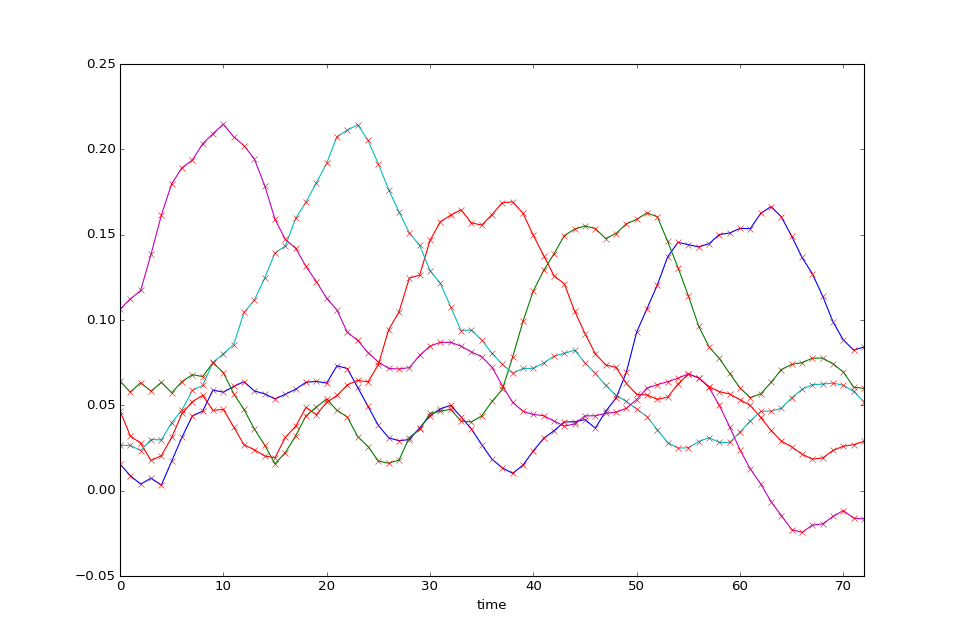

In [42]:
#plot
ax3=fres.unstack(level=0).plot(figsize=(12,8),legend=False)

As you can see above the forecasts are now unstacked in the 72 hour window

In [43]:
# we create a list of indeces for the time interval that we consider
all_dates = [tstart + datetime.timedelta(hours=12*x)
    for x in range(ndt)]

In [44]:
# fill in the gaps
fres=fres.unstack().reindex(all_dates).fillna(0).stack() # we use fillna(0) to work properly

In [45]:
fres=fres.replace('0',np.nan)  # replace all zeros with none

we can now check if it worked

In [46]:
fres.unstack() # see the zero values where there were none

h - TIFF                                          \
time                       0         1         2         3         4    
run date                                                                
2015-01-21 00:00:00  0.015611  0.008744  0.003833  0.007343  0.003224   
2015-01-21 12:00:00  0.064130  0.057747  0.063301  0.058243  0.063468   
2015-01-22 00:00:00  0.046765  0.032077  0.027747  0.017678  0.020494   
2015-01-22 12:00:00  0.026483  0.026507  0.023482  0.029977  0.029748   
2015-01-23 00:00:00  0.106417  0.112301  0.117307  0.138472  0.161369   

                                                                       \
time                       5         6         7         8         9    
run date                                                                
2015-01-21 00:00:00  0.017283  0.031346  0.043719  0.046646  0.058948   
2015-01-21 12:00:00  0.057350  0.063945  0.067963  0.066848  0.074958   
2015-01-22 00:00:00  0.031170  0.045236  0.052159  0.055863  0.047024   
2015-01-22 12:00:00  0.039807  0.047327  0.058720  0.061664  0.075158   
2015-01-23 00:00:00  0.179798  0.189233  0.193665  0.203306  0.209195   

                       ...                                             \
time                   ...           63        64        65        66   
run date               ...                                              
2015-01-21 00:00:00    ...     0.166452  0.160456  0.149120  0.136730   
2015-01-21 12:00:00    ...     0.063403  0.070944  0.073974  0.075002   
2015-01-22 00:00:00    ...     0.035309  0.029072  0.025634  0.021418   
2015-01-22 12:00:00    ...     0.046615  0.048264  0.054499  0.059324   
2015-01-23 00:00:00    ...    -0.006396 -0.014567 -0.022789 -0.024472   

                                                                       \
time                       67        68        69        70        71   
run date                                                                
2015-01-21 00:00:00  0.127079  0.114003  0.098933  0.088265  0.082386   
2015-01-21 12:00:00  0.077615  0.077675  0.074337  0.069531  0.060642   
2015-01-22 00:00:00  0.018502  0.019155  0.023596  0.026032  0.026935   
2015-01-22 12:00:00  0.062098  0.062445  0.063050  0.061738  0.058181   
2015-01-23 00:00:00 -0.020212 -0.019477 -0.015076 -0.011674 -0.016092   

                               
time                       72  
run date                       
2015-01-21 00:00:00  0.084164  
2015-01-21 12:00:00  0.059948  
2015-01-22 00:00:00  0.028892  
2015-01-22 12:00:00  0.051952  
2015-01-23 00:00:00 -0.016544  

[5 rows x 73 columns]

In [47]:
#plot and see that nothing changed
fres.unstack(level=0).plot(ax=ax3,color='red', linestyle='', marker='x',legend=False)

### Adjust the indeces in order to have the proper time tag

create a new full index

In [48]:
indexf=[[a for (a,b) in fres.index.tolist()],[item+datetime.timedelta(hours=ik) for [(item,ik)] in zip(fres.index)]]

In [49]:
pIndex3=pandas.MultiIndex.from_arrays(indexf,names=['run date','time'])

In [50]:
resf=pandas.DataFrame(fres.values,index=pIndex3,columns=['h - TIFF'])

<IPython.core.display.Javascript object>


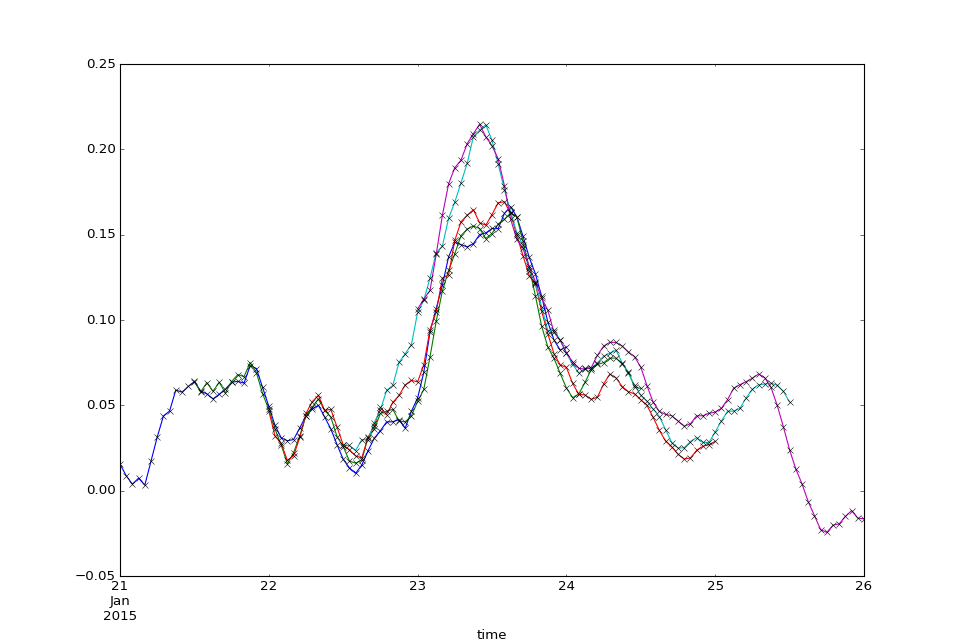

In [51]:
#plot
ax4=resf.unstack(level=0).plot(figsize=(12,8),legend=False)

In [52]:
# compare with original values
res1.unstack(level=0).plot(ax=ax4,color='k', linestyle='', marker='x',legend=False)

## stack them in columns

In [53]:
s=fres.unstack('run date')

In [54]:
sr=s[12:23] # sort with forecast window

In [55]:
sr

h - TIFF                                          \
run date 2015-01-21 00:00:00 2015-01-21 12:00:00 2015-01-22 00:00:00   
time                                                                   
12                  0.063863            0.047590            0.026863   
13                  0.058434            0.036129            0.023970   
14                  0.056730            0.026706            0.020330   
15                  0.053771            0.015754            0.019293   
16                  0.056477            0.022285            0.031215   
17                  0.059446            0.032154            0.037783   
18                  0.063513            0.043849            0.048776   
19                  0.064047            0.048935            0.044529   
20                  0.063028            0.053717            0.051711   
21                  0.073211            0.047070            0.055793   
22                  0.071564            0.043139            0.061960   
23                  0.060463            0.031707            0.064629   

                                                  
run date 2015-01-22 12:00:00 2015-01-23 00:00:00  
time                                              
12                  0.104422            0.202140  
13                  0.111599            0.194384  
14                  0.124555            0.178803  
15                  0.139321            0.159060  
16                  0.143388            0.147203  
17                  0.159538            0.142024  
18                  0.169109            0.131378  
19                  0.180391            0.122513  
20                  0.191821            0.112757  
21                  0.207482            0.105798  
22                  0.211226            0.092752  
23                  0.214395            0.088097

In [56]:
# create the time stamps
c1=[]
for head in sr.columns.levels[1]:
     c1.append([head+datetime.timedelta(hours=ik) for ik in sr.index.tolist()])

In [57]:
data=[]
for idat in xrange(sr.columns.levels[1].size):
    data=np.append(data,zip(c1[idat],sr.values.T[idat]))

data=data.reshape(-1,2)

In [58]:
dres=pandas.DataFrame(data, columns=['time','h']) # create dataset

In [59]:
dres['h']=pandas.to_numeric(dres['h'])

In [60]:
dres=dres.set_index('time') # set time as index

In [61]:
dres[:5]

,h
time,
2015-01-21 12:00:00,0.063863
2015-01-21 13:00:00,0.058434
2015-01-21 14:00:00,0.056730
2015-01-21 15:00:00,0.053771
2015-01-21 16:00:00,0.056477


<IPython.core.display.Javascript object>


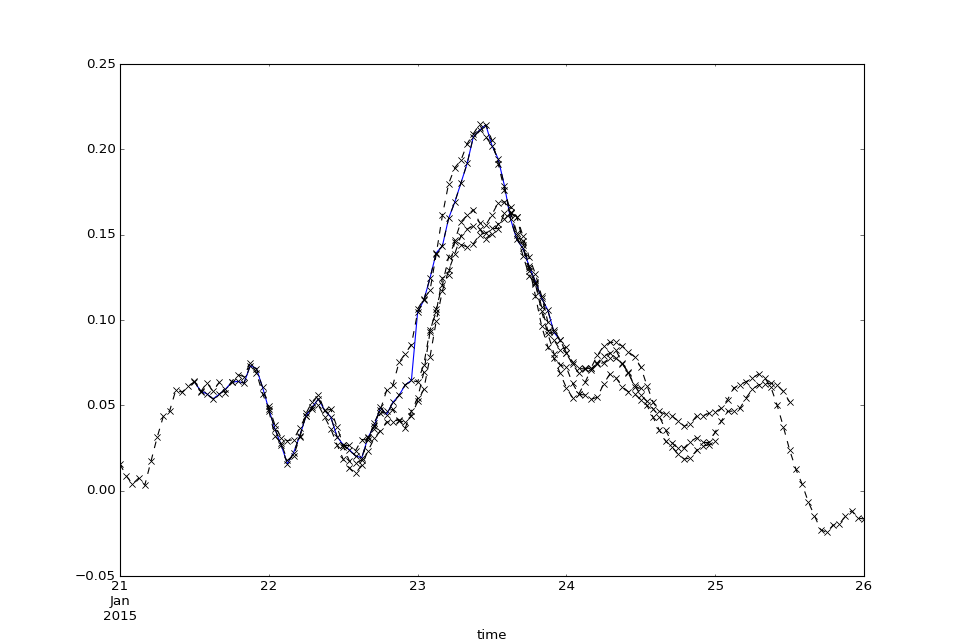

In [62]:
ax5=dres.plot(figsize=(12,8),legend=False)

In [67]:
# compare with original values
res1.unstack(level=0).plot(ax=ax5,color='k', linestyle='--', marker='x',legend=False)

## SAVE DATA in CSV

In [64]:
SAVEPATH='tmp/'#/mnt/pandora/Users_Critech/Thomas/HYFLUX/'

In [65]:
resf.to_csv(SAVEPATH+obs['NAME'][point].strip()+'.csv', header=None)

In [66]:
sr.to_csv(SAVEPATH+obs['NAME'][point].strip()+'24-48.csv')#,na_rep='nan')